# Overview
Over the past years, various approaches have emerged to tackle the challenge of predicting binding regions, particularly focusing on protein-ligand interaction sites. Depending on the available data, two approaches are possible: structure-based and sequence-based. While sequence-based methods rely solely on information extracted from the sequence, structure-based methods leverage insights gleaned from the three-dimensional structure of proteins.

## Sequence-based methods
In the first part of the lab, our exploration will center on predicting binding residues exclusively through analysis of the protein sequence. Recent advancements in protein language modelling (pLMs) have demonstrated competitive performance compared to state-of-the-art (SOTA) techniques for predicting protein-ligand binding residues.

## Structure-based methods
In the second part of the lab, we will replicate (with some delta) a well-known method for predicting binding sites called [DeepSite](https://academic.oup.com/bioinformatics/article/33/19/3036/3859178). Subsequently, we will assess the efficacy of this method in comparison to the sequence-based approaches developed in the first part of the lab.

### Download data

First, we download the data that will be needed throughout the labs. If you are running this notebook locally, please note that the archive size is about 3.5 GB and the unzipped content takes about 23 GB of disk space. If you are on Windows, some of the commands (such as wget) might not work. In that case, change the commands to Windows equivalents or carry out the jobs (such as downloading the data) outside of the notebook and skip the correponding cell.

In [2]:
!curl -O https://bioinformatics.cuni.cz/data/deepdata.tar.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 3603M    0  453k    0     0   416k      0  2:27:37  0:00:01  2:27:36  419k
  0 3603M    0 4351k    0     0  2087k      0  0:29:27  0:00:02  0:29:25 2095k
  0 3603M    0 8414k    0     0  2725k      0  0:22:33  0:00:03  0:22:30 2731k
  0 3603M    0 11.4M    0     0  2871k      0  0:21:25  0:00:04  0:21:21 2876k
  0 3603M    0 13.3M    0     0  2655k      0  0:23:09  0:00:05  0:23:04 3236k
  0 3603M    0 15.7M    0     0  2642k      0  0:23:16  0:00:06  0:23:10 3126k
  0 3603M    0 18.5M    0     0  2678k      0  0:22:57  0:00:07  0:22:50 2924k
  0 3603M    0 21.3M    0     0  2696k      0  0:22:48  0:00:08  0:22:40 2678k
  0 3603M    0 23.8M    0     0  2683k      0  0:22

Check that `deepdata.tar.gz` was downloaded successfully

In [1]:
import os
print(os.listdir())


['data', 'deepdata.tar.gz', 'original.ipynb', 'Prediction of binding regions.ipynb']


In [2]:
os.makedirs("data", exist_ok=True)

In [3]:
import tarfile
with tarfile.open("deepdata.tar.gz", "r:gz") as tar:
    tar.extractall(path="data")

C:\Users\nelia\AppData\Local\Temp\ipykernel_18768\4167115389.py:3: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="data")


### Data structure
1. `ADP-Training.txt`: CSV file; subset of the [Yu dataset](https://ieeexplore.ieee.org/document/6583160) (full dataset can be obtained [here](https://github.com/hamzagamouh/pt-lm-gnn/tree/main/datasets/yu_merged)) containing proteins with regions binding ADP ligand. Train set.
2. `ADP-Test.txt`: CSV file; subset of the Yu dataset containing proteins with regions binding ADP. Test set.
3. `embeddings` folder: ESM2 embeddings for each protein from the dataset.
4. `bert-embeddings` folder: BERT embeddings for proteins from the TRAIN set.
5. `voxel-features`: 3D voxels of proteins containing its features. It contains 8 channels: `aromatic`, `hbond_acceptor`, `hbond_donor`, `positive_ionizable`, `negative_ionizable`, `metal`, `occupancies`. The 3D voxels were computed using the [HTMD package](https://software.acellera.com/moleculekit/moleculekit.tools.voxeldescriptors.html).
6. `voxel-annotations`: 3D voxels of proteins containing information whether voxel is part of a binding site or not.
7. `train_dataset_i`: pre-processed subsets of the train set.
8. `test_dataset`: pre-processed subsets of the test set.

In [4]:
print(os.listdir("data"))

['ADP_Test.txt', 'ADP_Training.txt', 'bert-embeddings', 'embeddings', 'test_dataset.pickle', 'test_embeddings', 'train_dataset_0.pickle', 'train_dataset_1.pickle', 'train_dataset_2.pickle', 'train_dataset_3.pickle', 'train_dataset_4.pickle', 'train_dataset_5.pickle', 'train_dataset_6.pickle', 'train_dataset_7.pickle']


In [5]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import csv
from torch import nn
from sklearn.utils import class_weight
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

torch.manual_seed(0)

DATAPATH = 'data'


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
device

'cpu'

# PART1 - Predicting binding residues with protein language models
Here, we use protein embeddings directly to predict the binding residues. Embeddings for each residue from the dataset were precomputed using the ESM-2 protein language model. 

### Using dataset API to load the dataset

In [8]:
class SequenceYuDataset(Dataset):
    def __init__(self, _Xs, _Ys):
        Xs_list = None
        Ys_list = None
        for key in _Xs.keys():
            if Xs_list is None:
                Xs_list = _Xs[key]
                Ys_list = _Ys[key]
            else:
                Xs_list = np.concatenate((Xs_list,_Xs[key]), axis = 0)
                Ys_list = np.concatenate((Ys_list,_Ys[key]), axis = 0)

        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y


### Proccessing the dataset

In [9]:
def process_sequence_dataset(annotation_path, embeddings_path):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]

            # load the precomputed embedding
            if id not in Xs:
                filename = id + '.npy'
                embedding = np.load(f'{embeddings_path}/{filename}')
                Xs[id] = embedding

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for residue_idx in [int(residue[1:]) for residue in row[4].split(' ')]:
                # Yu dataset has 1-based indexing, so we need to subtract 1
                Ys[id][residue_idx - 1] = 1

    return Xs, Ys

In [10]:
Xs_train, Ys_train = process_sequence_dataset(f'{DATAPATH}/ADP_Training.txt', f'{DATAPATH}/embeddings')

train_dataset = SequenceYuDataset(Xs_train, Ys_train)

Xs_test, Ys_test = process_sequence_dataset(f'{DATAPATH}/ADP_Test.txt', f'{DATAPATH}/embeddings')

test_dataset = SequenceYuDataset(Xs_test, Ys_test)

In [11]:
print(len(train_dataset))
print(len(test_dataset))

102573
20715


### Defining a classifier
Create a classifier to predict whether residue is part of a binding site. The neural network has two layers and outputs one value indicating the probability of residue being a part of a binding site.

In [12]:
DROPOUT = 0.3
LAYER_WIDTH = 100
ESM2_DIM = 2560
class YuClassifier(nn.Module):
    def __init__(self, input_dim=ESM2_DIM):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3 = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout1(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


### Training imbalanced dataset
The dataset is heavily imbalanced (only ~5% of all residues are binding residues, the rest is non-binding), therefore we pass the `weight` argument to the loss function. But first, the weights need to be calculated using the `compute_class_weights(...)` function.

In [13]:
def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

torch.manual_seed(42)

### Train loop

In [14]:
model_0 = YuClassifier().to(device)
epochs = 80

# Create an optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.0001)

X_train, y_train = train_dataset[:]
X_test, y_test = test_dataset[:]

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train.numpy()).to(device)
# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

X_train, y_train = X_train.to(device), y_train.to(device).float()
X_test, y_test = X_test.to(device), y_test.to(device).float()

train_losses, test_losses = [], []

for epoch in range(epochs):
    ### TRAIN
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    train_losses.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### TEST
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_losses.append(test_loss.cpu().detach().numpy())

        # compute metrics on test dataset
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc = metrics.auc(fpr, tpr)

        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}")

Epoch: 0 | Loss: 1.71181, Accuracy: 76.31% | Test loss: 0.98155, AUC: 0.5930663469879339, MCC: 0.04127017838633244
Epoch: 10 | Loss: 0.89859, Accuracy: 79.64% | Test loss: 0.56226, AUC: 0.873298027199994, MCC: 0.3385737857061226
Epoch: 20 | Loss: 0.64869, Accuracy: 86.89% | Test loss: 0.48474, AUC: 0.9087455836308603, MCC: 0.38449914575286265
Epoch: 30 | Loss: 0.52783, Accuracy: 89.71% | Test loss: 0.44399, AUC: 0.9245592193683614, MCC: 0.4271866365427142
Epoch: 40 | Loss: 0.45159, Accuracy: 91.57% | Test loss: 0.42105, AUC: 0.9333635886419734, MCC: 0.4493466910952033
Epoch: 50 | Loss: 0.38616, Accuracy: 92.59% | Test loss: 0.41054, AUC: 0.938653924192954, MCC: 0.4743216109945182
Epoch: 60 | Loss: 0.33675, Accuracy: 93.36% | Test loss: 0.40353, AUC: 0.9423914103714405, MCC: 0.48368051933190165
Epoch: 70 | Loss: 0.29433, Accuracy: 94.29% | Test loss: 0.40722, AUC: 0.9449408234457545, MCC: 0.5086257850690065


### Comparing train and test loss

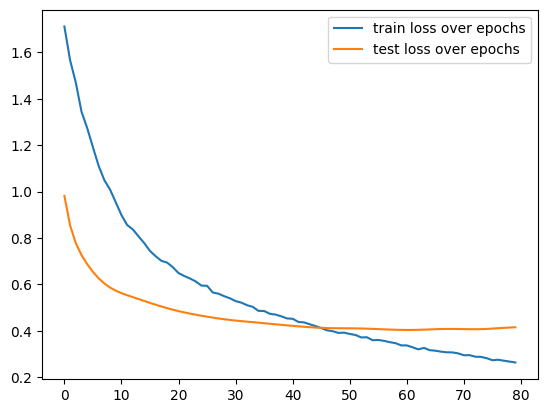

In [15]:
plt.plot(train_losses,label="train loss over epochs")
plt.plot(test_losses,label="test loss over epochs")
plt.legend()

### ROC curve
The dataset is imbalanced, therefore it is important to use a more complex metrics for evaluating the model appart from using only the accuracy (if we would predict everything as NON-BINDING, then we would achieve ~95% accuracy as most of the residues are NON-BINDING!).

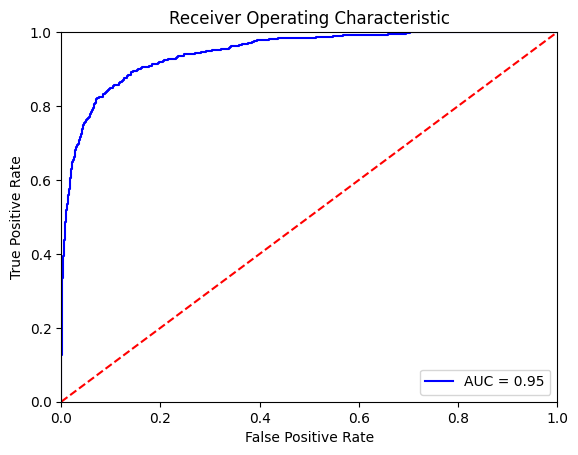

In [16]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Homework: Part 1
Create embeddings based on sequences from the annotation files using a different model (We'll give you hints for ProtBERT, but feel free to use any model of your own choice - ProtT5, Ankh, ...)

In [17]:
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert")

c:\Users\nelia\OneDrive\Рабочий стол\semester 2\DeepLife\.venv_deeplife\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Try the model on an example sequence

In [18]:
protein_sequences = ['MKALCLLLLPVLGLLVSSKTLCSMEEAINERIQEVAGSLIFRAISSIGLECQSVTSRGDLATCPRGFAVTGCTCGSACGSWDVRAETTCHCQCAGMDWTGARCCRVQPLEHHHHHH',
      'GSHMSLFDFFKNKGSAATATDRLKLILAKERTLNLPYMEEMRKEIIAVIQKYTKSSDIHFKTLDSNQSVETIEVEIILPR']

# the ProtBert takes aminoacids separated by a space as an input
# this snippet adds a space between each letter of the sequence
spaced_protein_sequences = [seq.replace("", " ")[1: -1] for seq in protein_sequences]

# generate an embedding
output = []
for seq in spaced_protein_sequences:
    encoded_input = tokenizer(seq, return_tensors='pt')

    # WARNING: you need to strip the embedding of the first and last vector, as those are the starting and terminating signs!
    output.append(model(**encoded_input).last_hidden_state.detach().numpy()[0][1:-1])

In [19]:
# SANITY CHECK: length of the sequence matches the number of generated embeddings
for i, seq in zip(output, protein_sequences):
    print(f'Embedding shape: {i.shape}, sequence length: {len(seq)}')

Embedding shape: (116, 1024), sequence length: 116
Embedding shape: (80, 1024), sequence length: 80


### TASK 1.
Use the BERT model to generate embeddings for the test set of the Yu dataset. To reduce the time needed for this exercise, we already precomputed the BERT embeddings for the proteins from the train set.


You can actually use any protein language model if you feel like it. Just keep in mind, that you need to compute the embeddings for both the train AND test sets, as we only precomputed the train embeddings for the BERT model.


Hints:
1. The sequences can be found in the CSV files `ADP_Training.txt`, `ADP_Test.txt`.
2. Don't forget to strip the embedding of the first and last vector, as those are the starting and terminating signs.

In [20]:
# extract sequences from the file 
test_sequences = []
with open("data/ADP_Test.txt", "r") as f:
    for line in f:
        parts = line.strip().split(";")
        if len(parts) == 6:
            sequence = parts[-1]
            test_sequences.append(sequence)

# extract train sequences from the file 
train_sequences = []
with open("data/ADP_Training.txt", "r") as f:
    for line in f:
        parts = line.strip().split(";")
        if len(parts) == 6:
            sequence = parts[-1]
            train_sequences.append(sequence)


In [21]:
# generate an embedding
output = []
for seq in test_sequences:
    encoded_input = tokenizer(seq, return_tensors='pt')

    output.append(model(**encoded_input).last_hidden_state.detach().numpy()[0][1:-1])

train_output = []
for seq in train_sequences:
    encoded_input = tokenizer(seq, return_tensors='pt')

    train_output.append(model(**encoded_input).last_hidden_state.detach().numpy()[0][1:-1])

In [22]:
model.eval()
embedding_output_dir = "bert_test_embed"   
with open("data/ADP_Test.txt") as f:
    reader = csv.reader(f, delimiter=";")
    for row in reader:

        pdb_id, chain, _, _, _, sequence = row
        protein_id = pdb_id.lower() + chain  # "3smsA"

        # Prepare sequence (space-separated amino acids)
        seq_spaced = " ".join(list(sequence))
        encoded_input = tokenizer(seq_spaced, return_tensors="pt")
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

        # Generate embedding
        with torch.no_grad():
            output = model(**encoded_input)
            embedding = output.last_hidden_state[0][1:-1]  # remove [CLS] and [SEP]

        # Save embedding to .npy file
        np.save(f"{"data/test_embeddings"}/{protein_id}.npy", embedding.cpu().numpy())  # shape: (L, 1024)


In [23]:
# check 
np.load(f'{DATAPATH}/test_embeddings/3smsA.npy').shape

(351, 1024)

### TASK 2.
Use the generated embeddings to train a model for the binding site prediction task, similarly as was shown earlier with the ESM-2 embeddings.

1. train the model using your novel embeddings
2. create the train/test loss graph
3. create the ROC curve: print the ROC curve for both models (the trained `YuClassifier` model and your new model)


Hints:
1. You can reuse the code from earlier: `YuClassifier` class, `proccess_dataset(...)`, the train loop or the code for creating the plots.
2. To train the model on ESM-2 using 80 epochs was enough. However, in the case of ProtBert, you might need to increase the number of epochs to train the model properly.
3. Don't worry if the ProtBert results don't match the ESM-2 results. As the ESM-2 model is more complex than the ProtBert model, it is expected achieve better results. On the other hand, generating ProtBert embeddings isn't as time-consuming as generating ESM-2 embeddings.

In [24]:
def process_sequence_dataset(annotation_path, embeddings_path):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]

            # load the precomputed embedding
            if id not in Xs:
                filename = id + '.npy'
                embedding = np.load(f'{embeddings_path}/{filename}')
                Xs[id] = embedding

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for residue_idx in [int(residue[1:]) for residue in row[4].split(' ')]:
                # Yu dataset has 1-based indexing, so we need to subtract 1
                Ys[id][residue_idx - 1] = 1


    return Xs, Ys

# Load test and train embeddings
x_train, y_train = process_sequence_dataset(f'{DATAPATH}/ADP_Training.txt', f'{DATAPATH}/bert-embeddings')
x_test, y_test = process_sequence_dataset(f'{DATAPATH}/ADP_Test.txt', f'{DATAPATH}/test_embeddings')


test_bert = SequenceYuDataset(x_test, y_test)
train_bert = SequenceYuDataset(x_train, y_train)


In [25]:
test_bert.Ys.shape, train_bert.Ys.shape

(torch.Size([20715]), torch.Size([102573]))

In [31]:
# train a YuClassifier on the BERT embeddings
model_1 = YuClassifier(input_dim=1024).to(device)
epochs = 250

# Create an optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.0001)

X_train, y_train = train_bert[:]
X_test, y_test = test_bert[:]

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train.numpy()).to(device)
# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

X_train, y_train = X_train.to(device), y_train.to(device).float()
X_test, y_test = X_test.to(device), y_test.to(device).float()

train_losses_1, test_losses_1 = [], []

for epoch in range(epochs):
    ### TRAIN
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    train_losses_1.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### TEST
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        test_losses_1.append(test_loss.cpu().detach().numpy())

        # compute metrics on test dataset
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        fpr_1, tpr_1, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc_1 = metrics.auc(fpr_1, tpr_1)

        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc_1}, MCC: {mcc}")



Epoch: 0 | Loss: 1.03018, Accuracy: 3.84% | Test loss: 0.98925, AUC: 0.4344032642971225, MCC: 0.0
Epoch: 10 | Loss: 1.02099, Accuracy: 13.29% | Test loss: 0.97954, AUC: 0.505399939687941, MCC: 0.016385556971738248
Epoch: 20 | Loss: 1.01143, Accuracy: 49.11% | Test loss: 0.96974, AUC: 0.5508804443732944, MCC: 0.025033175442553634
Epoch: 30 | Loss: 1.00067, Accuracy: 78.76% | Test loss: 0.95891, AUC: 0.5794698123252532, MCC: 0.04347427138843962
Epoch: 40 | Loss: 0.98768, Accuracy: 91.02% | Test loss: 0.94603, AUC: 0.599394496710759, MCC: 0.10551826116394106
Epoch: 50 | Loss: 0.97163, Accuracy: 94.10% | Test loss: 0.93036, AUC: 0.6202893117351631, MCC: 0.13399717350039594
Epoch: 60 | Loss: 0.95313, Accuracy: 94.68% | Test loss: 0.91163, AUC: 0.643921475188289, MCC: 0.1431166748017793
Epoch: 70 | Loss: 0.93241, Accuracy: 94.64% | Test loss: 0.89002, AUC: 0.6692212298447895, MCC: 0.1706183899201243
Epoch: 80 | Loss: 0.90815, Accuracy: 94.26% | Test loss: 0.86587, AUC: 0.6943658112530389, MC

Text(0.5, 1.0, 'Train/test loss graph of BERT-based model')

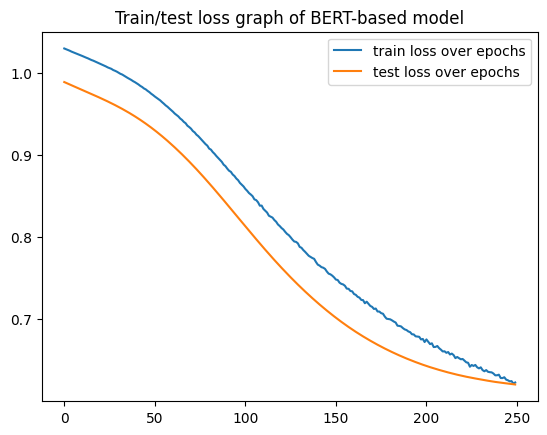

In [32]:
# 2. create the train/test loss graph

# train/test loss graph
plt.plot(train_losses_1,label="train loss over epochs")
plt.plot(test_losses_1,label="test loss over epochs")
plt.legend()
plt.title("Train/test loss graph of BERT-based model")  

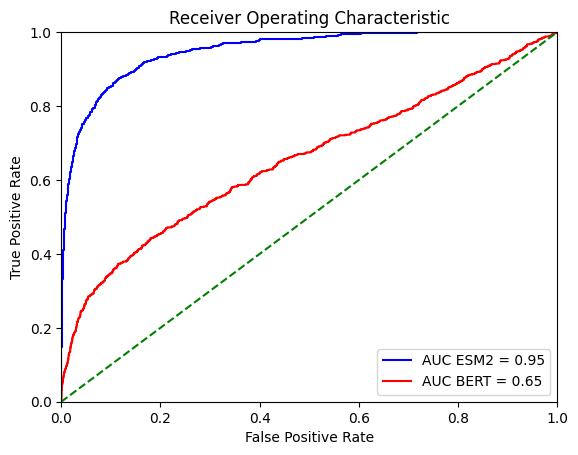

In [90]:
# 3. create the ROC curve: print the ROC curve for both models (the trained `YuClassifier` model and your new model)

# ROC curve for both models
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC ESM2 = %0.2f' % roc_auc)
plt.plot(fpr_1, tpr_1, 'r', label = 'AUC BERT = %0.2f' % roc_auc_1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'g--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### TASK
Don't forget to delete the data from the last task! Take a look if you don't keep any unnecessary/useless data in the memory.

In [72]:
import gc

del Xs_train, Ys_train, train_dataset, Xs_test, Ys_test, test_dataset
del tokenizer, model
del model_1, model_0

gc.collect()

20298

# PART 2 - Predicting binding residues from protein structure

In the second part, we will use the 3D structural information to predict binding regions. In the provided data, there are two folders - `voxel-features` with 3D `1x1x1 A^3` voxels, each containing eight channels (`hydrophobic`, `aromatic`, `hbond_acceptor`, `hbond_donor`, `positive_ionizable`, `negative_ionizable`, `metal`, `occupancies`) and `voxel-annotations` specifying the binding regions in each protein from the dataset. Overall,  the voxels form a 3D grid for each protein. The voxels were generated using the [HTMD package](https://software.acellera.com/moleculekit/moleculekit.tools.voxeldescriptors.html). However, because installing & running the package can be time-consuming, we prepared the voxels in advance.

The whole exercise is loosely based on the [DeepSite method](https://academic.oup.com/bioinformatics/article/33/19/3036/3859178).

## Overview of the method

We split the 3D grid into `32x32x32` windows using `step=16`. Then, we train a CNN using the extracted 3D windows to predict, whether the window is part of a binding region or not.

### Positive example
In our scenario, the `32x32x32` window is considered positive if at least one atom is derived from a binding residue. That's a significant simplification compared to the original DeepSite paper where the window is considered positive if its geometric center is closer than `4 A` to the pocket geometric center and negative otherwise. However, the simplified approach is sufficient for our purposes.


### Parameters
In real-world tools (like DeepSite), we might find out that the `WINDOW_SIZE` and `WINDOW_STEP` parameters might be finer (smaller window size with smaller steps). However, to reduce the computation time and resources, we use coarser windows here.

In [73]:
import gc

NUMBER_OF_SPLITS = 8

WINDOW_SIZE = 32
WINDOW_STEP = 16

# splits the protein into 3D windows
def sliding_window_3d(vector):
    vector = vector.unfold(1,WINDOW_SIZE,WINDOW_STEP)
    vector = vector.unfold(2,WINDOW_SIZE,WINDOW_STEP)
    vector = vector.unfold(3,WINDOW_SIZE,WINDOW_STEP)
    return vector.flatten(1, 3)


def pad_and_sliding_window_3d(x, y):
    pad1 = WINDOW_SIZE - x.shape[3] % WINDOW_SIZE if WINDOW_SIZE - x.shape[3] % WINDOW_SIZE > 0 else 0
    pad2 = WINDOW_SIZE - x.shape[2] % WINDOW_SIZE if WINDOW_SIZE - x.shape[2] % WINDOW_SIZE > 0 else 0
    pad3 = WINDOW_SIZE - x.shape[1] % WINDOW_SIZE if WINDOW_SIZE - x.shape[1] % WINDOW_SIZE > 0 else 0

    # to further reduce the resources, we use only float16. It would be ideal to use float64, but the limits from google colab environment do not let us to do that.
    # if you have access to larger resources, you can try out float64 and compare the performance
    x = torch.tensor(x, dtype=torch.float16)
    y = torch.tensor(y, dtype=torch.int8)

    # add padding to the voxel grid
    x = F.pad(x, (int(pad1 / 2), int(pad1 / 2) + (pad1 % 2 > 0),
        int(pad2 / 2), int(pad2 / 2) + (pad2 % 2 > 0),
        int(pad3 / 2), int(pad3 / 2) + (pad3 % 2 > 0)), mode='constant', value=0)
    y = F.pad(y, (int(pad1 / 2), int(pad1 / 2) + (pad1 % 2 > 0),
        int(pad2 / 2), int(pad2 / 2) + (pad2 % 2 > 0),
        int(pad3 / 2), int(pad3 / 2) + (pad3 % 2 > 0)), mode='constant', value=0)

    # split the protein into 3D windows
    x = sliding_window_3d(x)
    y = sliding_window_3d(y)

    return x,y

class VoxelYuDataset(Dataset):
    def __init__(self, _Xs= None, _Ys= None):
        self.Xs = None
        self.Ys = None

        if _Xs is None or _Ys is None:
            return
        counter = 1
        keys = list(_Xs.keys())
        for key in keys:
            print(key, ' ',counter, ' / ', len(keys), ' ')
            counter += 1

            x, y = pad_and_sliding_window_3d(_Xs[key], _Ys[key])
            y = y.sum(dim=[0,2,3,4]) > 0
            if self.Xs is None:
                self.Xs = x
                self.Ys = y
            else:
                self.Xs = torch.cat((self.Xs,x),1)
                self.Ys = torch.cat((self.Ys,y))

            if counter % 5 == 0:
                gc.collect()

            del _Xs[key]
            del _Ys[key]

        self.Xs = self.Xs.swapaxes(0,1)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y

### 3D CNN model definition
Let's create a 3D CNN model consisting of one convolutional layer, one pooling layer and two dense layers.

In [74]:
class VoxelYuCNN(nn.Module):
    def __init__(self):
        super(VoxelYuCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=8,
                               out_channels=2,
                               kernel_size = 5,
                               stride=2,
                               padding=2)



        self.maxpool1 = nn.MaxPool3d(kernel_size=3, stride=1, padding=1)

        self.dropout1 = nn.Dropout(0.25)

        self.linear1 = nn.Linear(8192, 2048)
        self.dropout2 = nn.Dropout(0.25)

        self.linear2 = nn.Linear(2048, 1)


    def forward(self, x):
        x = self.conv1(x)

        x = F.relu(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = torch.flatten(x,1)

        x = self.linear1(x)
        x = self.dropout2(x)
        x = F.relu(x)

        x = self.linear2(x)
        return x


In [75]:
def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


### Compute class weights
Similarly as in PART 1, the dataset is imbalanced. Normally we would compute the class weights from the whole dataset. However, as the whole dataset doesn't fit into the limits of google colab, we precomputed the class weights in advance.

In [77]:
# to save computational resources of google colab, we pre-computed the class weights
class_weights = torch.tensor([0.6570, 2.0919], device='cpu')

### Splitting the dataset into parts and loading each part separately
The google colab limits do not allow us to load the dataset at once. Therefore the dataset was partitioned in advance and each partition of the train set is saved in `./data/train_dataset_i.pickle` (`./data/test_dataset.pickle` for the test set). In each epoch during the train loop, we load the partitions one-by-one and delete the memory afterwards (`del` with `gc.collect()`) to not exceed the google colab limits.

# You might want to go get yourself a cup of coffee or tea, this might take a while!
Training the 3D CNN might take around ~10min.

In [78]:
import pickle

BATCH_SIZE = 2048

model_2 = VoxelYuCNN().to(device)

# Create an optimizer
optimizer = torch.optim.Adam(params=model_2.parameters(),
                            lr=0.0001)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
epochs = 5


for epoch in range(epochs):
    ### TRAIN
    print(f"Epoch {epoch}")

    model_2.train()

    for i in range(NUMBER_OF_SPLITS):
        with open(f'{DATAPATH}/train_dataset_{i}.pickle', 'rb') as f:
            print(f'Loading {i}th subset from pickle ...')
            train_subset = pickle.load(f)

        train_dataloader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)

        for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
            #print(f"Epoch {epoch}, batch {id_batch} / {batches}")

            X_train, y_train = x_batch.to(device), y_batch.to(device).float()

            y_logits = model_2(X_train.float()).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits,
                            y_train)
            acc = accuracy_fn(y_true=y_train,
                                y_pred=y_pred)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        # free memory so we don't exceed the google colab limits
        del train_subset, train_dataloader
        gc.collect()


Epoch 0
Loading 0th subset from pickle ...
Loading 1th subset from pickle ...
Loading 2th subset from pickle ...
Loading 3th subset from pickle ...
Loading 4th subset from pickle ...
Loading 5th subset from pickle ...
Loading 6th subset from pickle ...
Loading 7th subset from pickle ...
Epoch 1
Loading 0th subset from pickle ...
Loading 1th subset from pickle ...
Loading 2th subset from pickle ...
Loading 3th subset from pickle ...
Loading 4th subset from pickle ...
Loading 5th subset from pickle ...
Loading 6th subset from pickle ...
Loading 7th subset from pickle ...
Epoch 2
Loading 0th subset from pickle ...
Loading 1th subset from pickle ...
Loading 2th subset from pickle ...
Loading 3th subset from pickle ...
Loading 4th subset from pickle ...
Loading 5th subset from pickle ...
Loading 6th subset from pickle ...
Loading 7th subset from pickle ...
Epoch 3
Loading 0th subset from pickle ...
Loading 1th subset from pickle ...
Loading 2th subset from pickle ...
Loading 3th subset from

# Performance
Evaluate the performance of the 3D CNN on the test set

In [91]:
model_2.eval()

with torch.inference_mode():

    # prepare the test data
    with open(f'{DATAPATH}/test_dataset.pickle', 'rb') as f:
        print(f'Loading test subset from pickle ...')
        test_subset = pickle.load(f)

    test_dataloader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)
    
    # make the predictions (batch the predictions just in case GPU doesn't have enough memory)
    test_logits = None
    y_test = None

    for id_batch, (x_batch, y_batch) in enumerate(test_dataloader):
        if test_logits == None:
            test_logits = model_2(x_batch.float().to(device)).squeeze().to(device)
            y_test = y_batch
        else:
            test_logits = torch.cat((test_logits, model_2(x_batch.float().to(device)).squeeze()))
            y_test = torch.cat((y_test, y_batch))
    
    # compute the metrics
    test_pred = torch.round(torch.sigmoid(test_logits))
    y_test = y_test.to(device).float()
    test_loss = loss_fn(test_logits,
                        y_test.to(device))
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
    fpr_2, tpr_2, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
    roc_auc_2 = metrics.auc(fpr_2, tpr_2)
    mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    
    print(f"Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc_2}, MCC: {mcc}")

# cleanup
print('Run garbage collector ...')
del test_subset
gc.collect()

Loading test subset from pickle ...
Accuracy: 96.25% | Test loss: 2.01696, AUC: 0.8026513258904204, MCC: 0.4494986946336142
Run garbage collector ...


0

# Homework: Part 2
Create the ROC curve: print the ROC curve for all models into one plot (the trained `YuClassifier` model, the `ProtBert` model trained by you and the `VoxelYuCNN`)


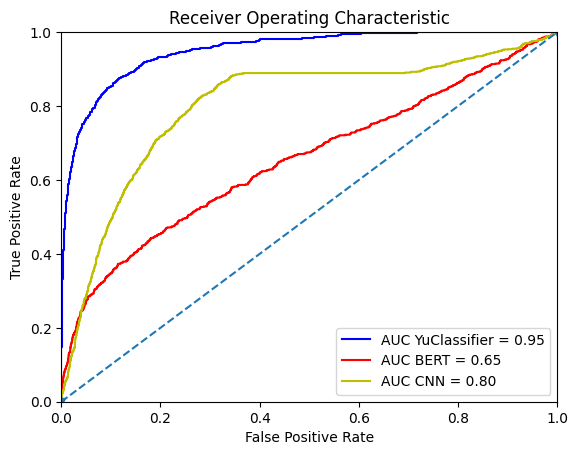

In [ ]:
# TODO:
# ROC curve for both models
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC YuClassifier = %0.2f' % roc_auc)
plt.plot(fpr_1, tpr_1, 'r', label = 'AUC BERT = %0.2f' % roc_auc_1)
plt.plot(fpr_2, tpr_2, 'y', label = 'AUC CNN = %0.2f' % roc_auc_2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'v--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()